![photo of capped vaccine](https://s.w-x.co/util/image/w/GettyImages-1280274196.jpg?crop=16:9&width=980&format=pjpg&auto=webp&quality=60)

# H1N1 Vaccine Predictive Modeling

## Business Understanding

The business problem outlined in the context of the dataset is related to public health efforts in the context of the COVID-19 pandemic. Specifically, the challenge is to predict whether individuals received the H1N1 flu vaccine or the seasonal flu vaccine based on data collected in the National 2009 H1N1 Flu Survey. According to the survey, there was a lower rate of H1N1 vaccination when compared to the seasonal vaccine.

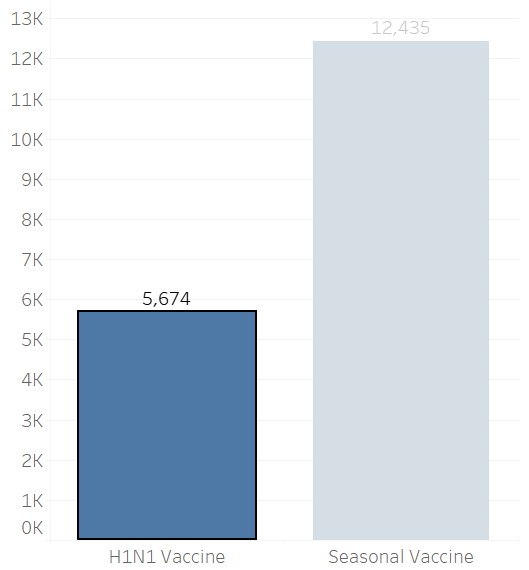

The importance of this prediction task lies in understanding the factors and patterns associated with individuals' vaccination decisions. By identifying the demographic, opinion, and health behavior variables that correlate with vaccine uptake, public health authorities can gain insights that may inform future vaccination campaigns. This information can help guide strategies to improve vaccination rates, tailor communication efforts, and address specific concerns or barriers that certain groups may have regarding flu vaccination.

This insight can be valuable for public health officials and policymakers in developing targeted and effective strategies to increase vaccination coverage and mitigate the impact of flu outbreaks.

## Data

The data we used was acquired from The National Institute of Health (NIH), found [here](Data from https://www.drivendata.org/competitions/66/flu-shot-learning/). There were 26,707 survey participants in the raw data.

### Preparation

In this stage, we initiated a feature selection procedure by randomly selecting features for incorporation into our predictive model. For efficient handling of categorical variables, we employed the OneHotEncoder, a methodology proficient in converting categorical data into a format conducive to analysis. Furthermore, we executed data scaling, centering it around the mean to guarantee uniformity. Addressing imbalances within our dataset, we deployed the Synthetic Minority Over-sampling Technique (SMOTE) to resample the data, augmenting the representation of minority classes and fortifying the model's robustness. Additionally, in an effort to manage missing values, we adopted a strategy of dropping columns with null values. After cleaning the data, there were 13,506 subjects that remained. GridSearchCV was used to adjust parameters.

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,classification_report, auc, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve, precision_score, accuracy_score

## Explorations 

In [2]:
#Reading the dataset 
df_f = pd.read_csv("data/training_set_features.csv")
df_f

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [3]:
# Get a list of column names with dtype 'object'
cat_columns = df_f.select_dtypes(include=['object']).columns.tolist()
num_columns = df_f.select_dtypes(exclude=['object']).columns.tolist()
df_f_cat = df_f[cat_columns]
df_f_num = df_f[num_columns]

In [4]:
df_f_num.corr()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,1.000000,0.017839,0.003425,-0.008475,0.009638,-0.006644,0.011105,0.004539,0.009011,0.007575,...,-0.003149,-0.012603,0.005912,0.000958,-0.002270,0.005935,-0.005291,0.009563,0.000187,-0.003726
h1n1_concern,0.017839,1.000000,0.062522,0.090301,0.233713,0.156032,0.293565,0.255031,0.246424,0.248016,...,0.033562,-0.003655,0.239604,0.377033,0.360070,0.235136,0.333990,0.225731,-0.015658,0.050525
h1n1_knowledge,0.003425,0.062522,1.000000,-0.010836,0.088839,0.030050,0.089785,-0.048898,-0.068219,0.086162,...,0.170252,0.119408,0.121009,0.073086,-0.019501,0.086103,0.076825,-0.062483,0.024874,0.050583
behavioral_antiviral_meds,-0.008475,0.090301,-0.010836,1.000000,0.049247,0.146261,0.064119,0.106287,0.127679,0.070868,...,0.009465,-0.063988,0.030211,0.105163,0.079091,0.015003,0.085315,0.084305,0.044900,0.084822
behavioral_avoidance,0.009638,0.233713,0.088839,0.049247,1.000000,0.064946,0.338130,0.227675,0.220348,0.335335,...,0.001180,0.032662,0.112300,0.117851,0.131405,0.119554,0.129504,0.082942,0.019122,0.040328
behavioral_face_mask,-0.006644,0.156032,0.030050,0.146261,0.064946,1.000000,0.083363,0.180907,0.163382,0.104335,...,0.069992,-0.040257,0.037651,0.131165,0.107129,0.041556,0.110161,0.090009,0.013991,0.005826
behavioral_wash_hands,0.011105,0.293565,0.089785,0.064119,0.338130,0.083363,1.000000,0.195364,0.192619,0.365064,...,0.053761,0.031919,0.136987,0.168711,0.150024,0.138517,0.172464,0.088029,0.009669,0.047764
behavioral_large_gatherings,0.004539,0.255031,-0.048898,0.106287,0.227675,0.180907,0.195364,1.000000,0.584085,0.253683,...,-0.032319,-0.059000,0.052299,0.126463,0.185924,0.078491,0.132865,0.135446,-0.031938,-0.009449
behavioral_outside_home,0.009011,0.246424,-0.068219,0.127679,0.220348,0.163382,0.192619,0.584085,1.000000,0.267719,...,-0.034619,-0.061381,0.050748,0.125549,0.174834,0.067469,0.120237,0.138133,-0.027527,-0.009558
behavioral_touch_face,0.007575,0.248016,0.086162,0.070868,0.335335,0.104335,0.365064,0.253683,0.267719,1.000000,...,0.067648,0.011024,0.104126,0.146080,0.131772,0.105798,0.143735,0.090097,-0.000553,0.023606


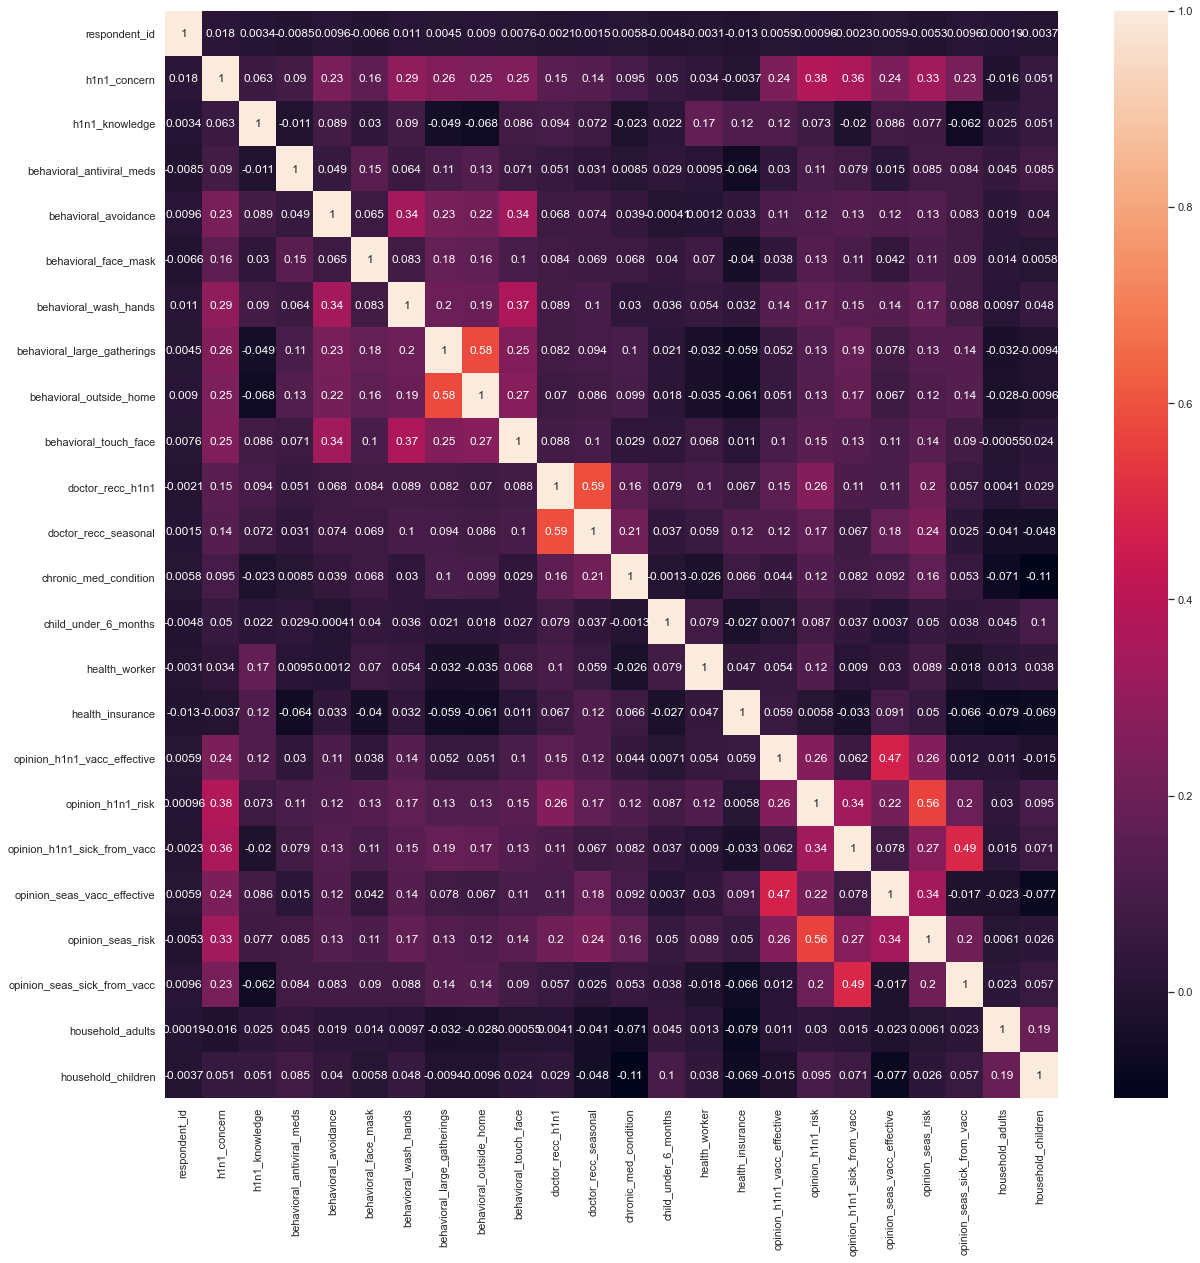

In [5]:
#correlation visualisation for 


sns.set(rc={'figure.figsize':(20, 20)})

# Use the .heatmap function to depict the relationships visually!
sns.heatmap(df_f_num.corr(), annot=True);

In [6]:
#Exploring the target database
df_t = pd.read_csv("data/training_set_labels.csv")
df_t['h1n1_vaccine']

0        0
1        0
2        0
3        0
4        0
        ..
26702    0
26703    0
26704    0
26705    0
26706    0
Name: h1n1_vaccine, Length: 26707, dtype: int64

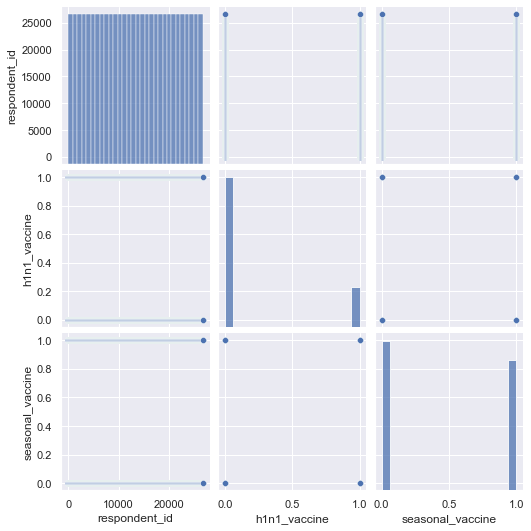

In [7]:
sns.pairplot(df_t)

In [8]:
# features selection
col_n_na= ['age_group','race','sex','hhs_geo_region','census_msa']

In [9]:
#creating X1 dataframe
X1 = df_f_cat[col_n_na]
X1

,age_group,race,sex,hhs_geo_region,census_msa
0,55 - 64 Years,White,Female,oxchjgsf,Non-MSA
1,35 - 44 Years,White,Male,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,White,Male,qufhixun,"MSA, Not Principle City"
3,65+ Years,White,Female,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,White,Female,qufhixun,"MSA, Not Principle City"
...,...,...,...,...,...
26702,65+ Years,White,Female,qufhixun,Non-MSA
26703,18 - 34 Years,White,Male,lzgpxyit,"MSA, Principle City"
26704,55 - 64 Years,White,Female,lzgpxyit,"MSA, Not Principle City"
26705,18 - 34 Years,Hispanic,Female,lrircsnp,Non-MSA


#### Some Visualizations of the Data

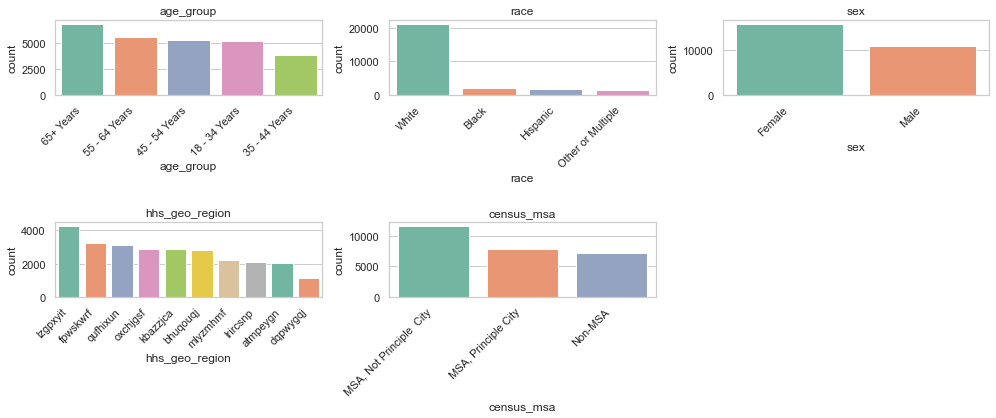

In [10]:
#visualization 
sns.set(style="whitegrid")

# Plotting X1
plt.figure(figsize=(14, 10))
for i, column in enumerate(X1):
    plt.subplot(4, 3, i + 1)
    sns.countplot(x=column, data=X1, palette="Set2", order= X1[column].value_counts().index)
    plt.title(column)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### One Hot Encoding

In [11]:
# One-hot encode the categorical columns

#Instantiate the model 
ohe = OneHotEncoder()


X1_clean = ohe.fit_transform(X1).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
X1_ohe_df = pd.DataFrame(X1_clean, columns=ohe.get_feature_names(X1.columns))

X1_ohe_df.head()

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,...,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


The dataframe was merged with the target variable: H1N1 vaccine.

In [12]:
#merging with the target h1n1 vaccine
X_n = pd.concat([df_f[num_columns], df_t['h1n1_vaccine']], axis=1)

In [13]:
#Merging all together
X_c = pd.concat([X1_ohe_df, X_n], axis=1)
X_c.isna().sum()

age_group_18 - 34 Years                    0
age_group_35 - 44 Years                    0
age_group_45 - 54 Years                    0
age_group_55 - 64 Years                    0
age_group_65+ Years                        0
race_Black                                 0
race_Hispanic                              0
race_Other or Multiple                     0
race_White                                 0
sex_Female                                 0
sex_Male                                   0
hhs_geo_region_atmpeygn                    0
hhs_geo_region_bhuqouqj                    0
hhs_geo_region_dqpwygqj                    0
hhs_geo_region_fpwskwrf                    0
hhs_geo_region_kbazzjca                    0
hhs_geo_region_lrircsnp                    0
hhs_geo_region_lzgpxyit                    0
hhs_geo_region_mlyzmhmf                    0
hhs_geo_region_oxchjgsf                    0
hhs_geo_region_qufhixun                    0
census_msa_MSA, Not Principle  City        0
census_msa

Here we checked on features that were correlated to the target.

In [14]:
#lets check the features highly correlated to our target
X_c.corr()

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,...,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine
age_group_18 - 34 Years,1.000000,-0.202105,-0.243313,-0.252668,-0.289120,0.027414,0.123630,0.063551,-0.131630,-0.055495,...,-0.184425,-0.014708,0.027698,0.016915,-0.077216,-0.022405,0.037537,0.180557,0.202008,-0.027005
age_group_35 - 44 Years,-0.202105,1.000000,-0.202659,-0.210450,-0.240812,0.012561,0.054278,0.024060,-0.055878,-0.008218,...,-0.038001,-0.013392,0.044911,0.027925,-0.057703,-0.003092,0.027391,0.043901,0.374839,-0.014733
age_group_45 - 54 Years,-0.243313,-0.202659,1.000000,-0.253360,-0.289912,0.002652,-0.011495,-0.003627,0.007415,0.007257,...,-0.017152,0.004651,0.004947,0.016475,-0.038212,-0.018482,0.016108,0.065041,0.036191,-0.021401
age_group_55 - 64 Years,-0.252668,-0.210450,-0.253360,1.000000,-0.301058,-0.008590,-0.055283,-0.026241,0.055123,-0.006605,...,0.028715,0.019189,-0.006915,-0.010897,0.031172,0.018572,-0.008543,-0.036054,-0.221260,0.038122
age_group_65+ Years,-0.289120,-0.240812,-0.289912,-0.301058,1.000000,-0.029420,-0.094043,-0.049354,0.106455,0.056546,...,0.183171,0.001986,-0.059272,-0.042616,0.122126,0.022328,-0.062716,-0.223004,-0.307980,0.020377
race_Black,0.027414,0.012561,0.002652,-0.008590,-0.029420,1.000000,-0.077836,-0.074384,-0.577294,0.027758,...,-0.049174,-0.031554,-0.004149,0.054422,-0.046673,-0.035894,0.069845,-0.033967,0.025990,-0.045725
race_Hispanic,0.123630,0.054278,-0.011495,-0.055283,-0.094043,-0.077836,1.000000,-0.067216,-0.521664,-0.017255,...,-0.180440,-0.010816,0.087256,0.091554,-0.022163,0.045119,0.117005,0.093778,0.157674,-0.002902
race_Other or Multiple,0.063551,0.024060,-0.003627,-0.026241,-0.049354,-0.074384,-0.067216,1.000000,-0.498533,-0.029186,...,-0.026516,-0.024795,0.016132,0.042645,-0.041791,-0.004496,0.034356,0.041259,0.023133,0.002508
race_White,-0.131630,-0.055878,0.007415,0.055123,0.106455,-0.577294,-0.521664,-0.498533,1.000000,0.009222,...,0.157578,0.042319,-0.060378,-0.117768,0.069384,-0.001160,-0.138940,-0.059339,-0.128062,0.030887
sex_Female,-0.055495,-0.008218,0.007257,-0.006605,0.056546,0.027758,-0.017255,-0.029186,0.009222,1.000000,...,0.065238,0.017144,0.093023,0.090731,0.051251,0.091096,0.042407,-0.064799,0.028112,0.020672


Null values were dropped from the dataframe.

In [15]:
#dropping the missing values 
X_cm= X_c.dropna()
X_cm.isna().sum()

age_group_18 - 34 Years                0
age_group_35 - 44 Years                0
age_group_45 - 54 Years                0
age_group_55 - 64 Years                0
age_group_65+ Years                    0
race_Black                             0
race_Hispanic                          0
race_Other or Multiple                 0
race_White                             0
sex_Female                             0
sex_Male                               0
hhs_geo_region_atmpeygn                0
hhs_geo_region_bhuqouqj                0
hhs_geo_region_dqpwygqj                0
hhs_geo_region_fpwskwrf                0
hhs_geo_region_kbazzjca                0
hhs_geo_region_lrircsnp                0
hhs_geo_region_lzgpxyit                0
hhs_geo_region_mlyzmhmf                0
hhs_geo_region_oxchjgsf                0
hhs_geo_region_qufhixun                0
census_msa_MSA, Not Principle  City    0
census_msa_MSA, Principle City         0
census_msa_Non-MSA                     0
respondent_id   

The shape of the dataframe was checked to mitigate any potential errors.

In [16]:
#Sanity check
X_cm.shape

(13506, 49)

In [17]:
#determine X_sm and y_sm 
X_sm= X_cm.drop('h1n1_vaccine', axis =1)
y_sm =X_cm['h1n1_vaccine']

In [18]:
# Performing the split test
X_tr_samp, X_te_samp, y_tr_samp, y_te_samp = train_test_split(
    X_sm, y_sm,random_state=42)

In [19]:
#Sanity check
y_sm.value_counts()

0    9475
1    4031
Name: h1n1_vaccine, dtype: int64

In [20]:
#Scaling the the data
scaler = StandardScaler()
scaler.fit(X_tr_samp)
X_tr_sc = scaler.transform(X_tr_samp)
X_te_sc = scaler.transform(X_te_samp)

#### SMOTE

In [21]:
from imblearn.over_sampling import SMOTE
# Instantiate our SMOTE
sm = SMOTE(random_state=42)
# Fit and resample on the training data! X_tr_samp, y_tr_samp
X_tr_smote, y_tr_smote = sm.fit_resample(X_tr_sc, y_tr_samp)

In [22]:
#sanity check 
y_tr_smote.value_counts()

1    7069
0    7069
Name: h1n1_vaccine, dtype: int64

### Dummy Model

In [23]:
#Instantiate our model
dummy_model = DummyClassifier(strategy='most_frequent')
#fitting the data to the model 
dummy_model.fit(X_tr_smote, y_tr_smote)
#model prediction 
dummy_model.predict(X_tr_smote)
#Accuracy score
print ('This is the accuracy score:', dummy_model.score(X_tr_smote,  y_tr_smote))

This is the accuracy score: 0.5


In [24]:
class mcalculation():
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        self.precision_results = None  # New attribute for precision
        self.precision_mean = None
        self.precision_median = None
        self.precision_std = None
        #
        if cv_now:
            self.cross_validate()

    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.

        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''

        cv_X = X if X else self.X
        cv_y = y if y else self.y

        # Accuracy scores
        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        # Precision scores
        y_pred = cross_val_predict(self.model, cv_X, cv_y, cv=kfolds)
        self.precision_results = [precision_score(cv_y, y_pred)]
        self.precision_mean = np.mean(self.precision_results)
        self.precision_median = np.median(self.precision_results)
        self.precision_std = np.std(self.precision_results)

    def print_cv_summary(self):
        cv_summary = (
            f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
            {self.precision_mean:.5f} ± {self.precision_std:.5f} precision
        ''')
        print(cv_summary)

    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
            y=self.cv_results,
            color='orange',
            size=10,
            alpha=0.8,
            ax=ax
        )

        return ax

Evaluation of accuracy & precision score.

In [25]:
# Accuracy, Precision metric calculation
rf_clf_sm_model_results = mcalculation(
                        model=dummy_model,
                        model_name='Dummy Model ',
                        X=X_tr_smote, 
                        y=y_tr_smote
);
rf_clf_sm_model_results.print_cv_summary()

CV Results for `Dummy Model ` model:
            0.49993 ± 0.00014 accuracy
            0.49965 ± 0.00000 precision
        


In [26]:
#Defining the evaluate model performance function
def evaluate_model_performance(model, X_train_scaled, y_train):
  
    # Calculate roc-auc for train set
    train_probs = model.predict_proba(X_train_scaled)[:, 1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Plot ROC curves
    plt.figure(figsize=(12, 6))

  

    # Plot ROC curve for train set
    plt.subplot(1, 2, 2)
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_train))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train Set')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

Plot of ROC curve

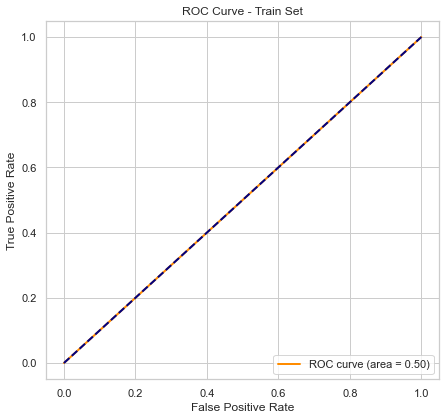

In [27]:
#Model performance evaluation
evaluate_model_performance(dummy_model, X_tr_smote, y_tr_smote)

In [28]:
#dummy model cross validation 
cv_results = cross_val_score(dummy_model,X_tr_smote,y_tr_smote, cv=5)
cv_results.mean()

0.4999292536257517

### Decision Tree - Model 1
A decision tree was used as our primary model, which stems from its capacity for binary classification. Decision trees can also deal with relationships that have a less linear relationship, which is what we typically see with survey data. Survey data is also typically highly dimensional related to a binary concept, which also led us to use a decision tree.

In [29]:
#instantiation 
rf_clf_sm = DecisionTreeClassifier(random_state=42)
#fitting the model 
rf_clf_sm.fit(X_tr_smote, y_tr_smote)

DecisionTreeClassifier(random_state=42)

In [30]:
class mcalculation():
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        self.precision_results = None  # New attribute for precision
        self.precision_mean = None
        self.precision_median = None
        self.precision_std = None
        #
        if cv_now:
            self.cross_validate()

    def cross_validate(self, X=None, y=None, kfolds=10):
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        # Accuracy scores
        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        # Precision scores
        y_pred = cross_val_predict(self.model, cv_X, cv_y, cv=kfolds)
        self.precision_results = [precision_score(cv_y, y_pred)]
        self.precision_mean = np.mean(self.precision_results)
        self.precision_median = np.median(self.precision_results)
        self.precision_std = np.std(self.precision_results)

    def print_cv_summary(self):
        cv_summary = (
            f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
            {self.precision_mean:.5f} ± {self.precision_std:.5f} precision
        ''')
        print(cv_summary)

    def plot_cv(self, ax):
    
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
            y=self.cv_results,
            color='orange',
            size=10,
            alpha=0.8,
            ax=ax
        )

        return ax

Another check of the accuracy & precision scores.

In [31]:
# Accuracy, Precision metric calculation
rf_clf_sm_model_results = mcalculation(
                        model=rf_clf_sm ,
                        model_name='Decision Tree',
                        X=X_tr_smote, 
                        y=y_tr_smote
);
rf_clf_sm_model_results.print_cv_summary()

CV Results for `Decision Tree` model:
            0.79623 ± 0.09573 accuracy
            0.79635 ± 0.00000 precision
        


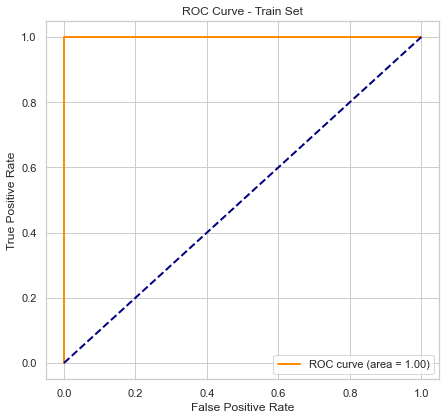

In [32]:
#model performance evaluation
evaluate_model_performance(rf_clf_sm, X_tr_smote, y_tr_smote)

Cross-validation results

In [33]:
cv_results = cross_val_score(rf_clf_sm, X_tr_smote, y_tr_smote, cv=5)
cv_results.mean()

0.7892312410785269

GridSearchCV used to look for best parameters, starting with max depth.

In [34]:
#Using Grid search to look for the best parameters
param_grid = {
    'max_depth': [5, 10, 20],
}

rf_model = DecisionTreeClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tr_smote, y_tr_smote)

#Best parameters
print("Best parameters found: ", grid_search.best_params_)

#Best cross-validated score
print("Best cross-validated accuracy: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'max_depth': 10}
Best cross-validated accuracy: 0.83


Another grid search was used with a few more parameters to tune the model.

In [35]:
#Using Grid search to look for the best parameters

param_grid = {
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [1,2,3],
    'min_samples_split':[8,10,12],
}

rf_model = DecisionTreeClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tr_smote, y_tr_smote)

#Best parameters
print("Best parameters found: ", grid_search.best_params_)

#Best cross-validated score
print("Best cross-validated accuracy: {:.2f}".format(grid_search.best_score_))



Best parameters found:  {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 8}
Best cross-validated accuracy: 0.83


In [36]:
#Using Grid search to look for the best parameters

param_grid = {
    'max_depth': [7, 8, 9],
    'min_samples_leaf': [1,2,3],
    'min_samples_split':[9,10,11],
}

rf_model = DecisionTreeClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tr_smote, y_tr_smote)

#Best parameters
print("Best parameters found: ", grid_search.best_params_)

#Best cross-validated score
print("Best cross-validated accuracy: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 10}
Best cross-validated accuracy: 0.83


One more grid search used to tune the model a little more.

In [37]:
#Using Grid search to look for the best parameters
param_grid = {
    'max_depth': [8],
    'min_samples_leaf': [2],
    'min_samples_split':[10,11, 12],
}

rf_model = DecisionTreeClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tr_smote, y_tr_smote)

#Best parameters
print("Best parameters found: ", grid_search.best_params_)

#Best cross-validated score
print("Best cross-validated accuracy: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 11}
Best cross-validated accuracy: 0.83


### Decision Tree - Model 2

In [38]:
#instantiation 
rf_clf_sm2 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=11,random_state=42)
#fitting the model 
rf_clf_sm2.fit(X_tr_smote, y_tr_smote)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=11,
                       random_state=42)

In [39]:
# Accuracy, Precision metric calculation
rf_clf_sm2_model_results = mcalculation(
                        model=rf_clf_sm2 ,
                        model_name='Decision Tree 2',
                        X=X_tr_smote, 
                        y=y_tr_smote
);
rf_clf_sm2_model_results.print_cv_summary()

CV Results for `Decision Tree 2` model:
            0.83209 ± 0.07959 accuracy
            0.87893 ± 0.00000 precision
        


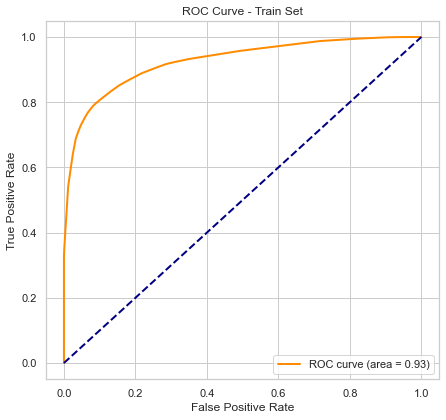

In [40]:
#model performance evaluation
evaluate_model_performance(rf_clf_sm2, X_tr_smote, y_tr_smote)

In [41]:
#cross validation score
cv_results2 = cross_val_score(rf_clf_sm2, X_tr_smote, y_tr_smote, cv=5)
cv_results2.mean()

0.8279907229188733

In [42]:
#Using Grid search to look for the best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]

}
#instatiate r_model 
rf_model = DecisionTreeClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tr_smote, y_tr_smote)

#Best parameters
print("Best parameters found: ", grid_search.best_params_)

#Best cross-validated score
print("Best cross-validated accuracy: {:.2f}".format(grid_search.best_score_))



Best parameters found:  {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validated accuracy: 0.82


### Decision Tree - Model 3

In [43]:
#instantiation 
rf_clf_sm3 = DecisionTreeClassifier(max_depth=7,min_samples_leaf=4,min_samples_split=5,random_state=42)
#fitting the model 
rf_clf_sm3.fit(X_tr_smote, y_tr_smote)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)

In [44]:
# Accuracy, Precision metric calculation
rf_clf_sm3_model_results = mcalculation(
                        model=rf_clf_sm3 ,
                        model_name='Decision Tree 3',
                        X=X_tr_smote, 
                        y=y_tr_smote
);
rf_clf_sm3_model_results.print_cv_summary()

CV Results for `Decision Tree 3` model:
            0.82417 ± 0.07288 accuracy
            0.86918 ± 0.00000 precision
        


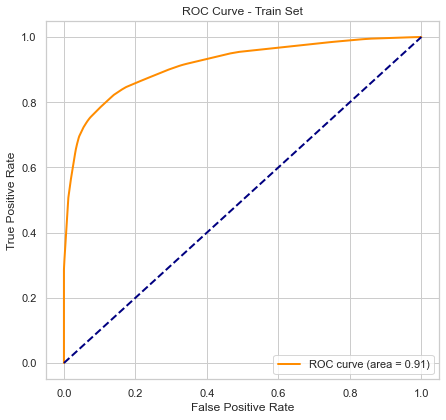

In [45]:
#model performance evaluation
evaluate_model_performance(rf_clf_sm3, X_tr_smote, y_tr_smote)

In [46]:
#cross validation score
cv_results3 = cross_val_score(rf_clf_sm3, X_tr_smote, y_tr_smote, cv=5)
cv_results3.mean()

0.8219784068456872

In [47]:
print('Model 1: ')
rf_clf_sm_model_results.print_cv_summary(), 
print('cross validation2:',cv_results.mean())
print('\n')
print('======================================')
print('Model 2: ')
rf_clf_sm2_model_results.print_cv_summary()
print('cross validation2:',cv_results2.mean())
print('\n')
print('======================================')
print('Model 3: ')
rf_clf_sm3_model_results.print_cv_summary()
print('cross validation3:',cv_results3.mean())


Model 1: 
CV Results for `Decision Tree` model:
            0.79623 ± 0.09573 accuracy
            0.79635 ± 0.00000 precision
        
cross validation2: 0.7892312410785269


Model 2: 
CV Results for `Decision Tree 2` model:
            0.83209 ± 0.07959 accuracy
            0.87893 ± 0.00000 precision
        
cross validation2: 0.8279907229188733


Model 3: 
CV Results for `Decision Tree 3` model:
            0.82417 ± 0.07288 accuracy
            0.86918 ± 0.00000 precision
        
cross validation3: 0.8219784068456872


## Model 2: Evaluation on the test set

Precision and accuracy scores took root as our metrics for model evaluation. Our objective was to prune false positives, in other words: mitigate instances where predictions indicated vaccination among individuals who, in reality, did not receive the vaccine.

Initially, our dummy model demonstrated an accuracy rate of approximately 79% with precision at 78%. After using GridSearchCV to tune our model, it performed with 83% accuracy & 88% precision on the training data, while it was 80% accurate with 70% precision on the testing data.

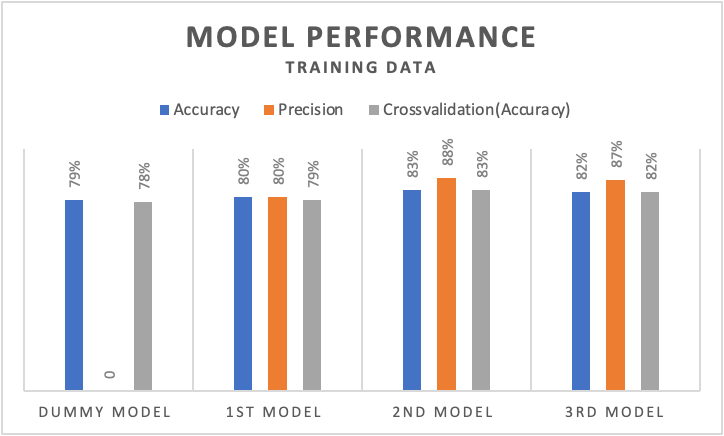

This graph shows the performance for our models after tuning, similar to how you would tune a radio for the best signal. Our second model did the best, so we chose that one for our testing data.

In [48]:
#Calculating the precision Score
precision_score(y_te_samp, rf_clf_sm2.predict(X_te_sc))

0.7007481296758105

In [49]:
#Calculating the accuracy Score
accuracy_score(y_te_samp, rf_clf_sm2.predict(X_te_sc))

0.8078175895765473

In [50]:
def evaluate_model_performance(model, X_train_scaled, y_train):
    #X_test_scaled, y_test
    # Calculate roc-auc for test set
    #test_probs = model.predict_proba(X_test_scaled)[:, 1]
   # fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_probs)
   # roc_auc_test = auc(fpr_test, tpr_test)

    # Print AUC for the test set
   # print('\nAUC for Test Set is: {:.2f}'.format(roc_auc_test))

    # Calculate roc-auc for train set
    train_probs = model.predict_proba(X_train_scaled)[:, 1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Print AUC for the train set
    #print('\nAUC for Train Set is: {:.2f}'.format(roc_auc_train))

    # Plot ROC curves
    plt.figure(figsize=(12, 6))

    # Plot ROC curve for test set
   # plt.subplot(1, 2, 1)
    #plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_test))
   # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   # plt.xlabel('False Positive Rate')
   # plt.ylabel('True Positive Rate')
   # plt.title('ROC Curve - Test Set')
    #plt.legend(loc='lower right')

    # Plot ROC curve for train set
    plt.subplot(1, 2, 2)
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_train))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train Set')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Create and print a confusion matrix
   # print('\nConfusion Matrix')
  #  print('----------------')
    #y_pred = model.predict(X_test_scaled)
   # confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
  #  print(confusion_matrix)

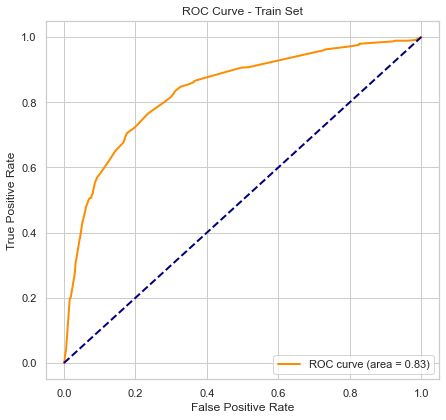

In [51]:
#model performance evaluation
evaluate_model_performance( rf_clf_sm2, X_te_sc, y_te_samp)

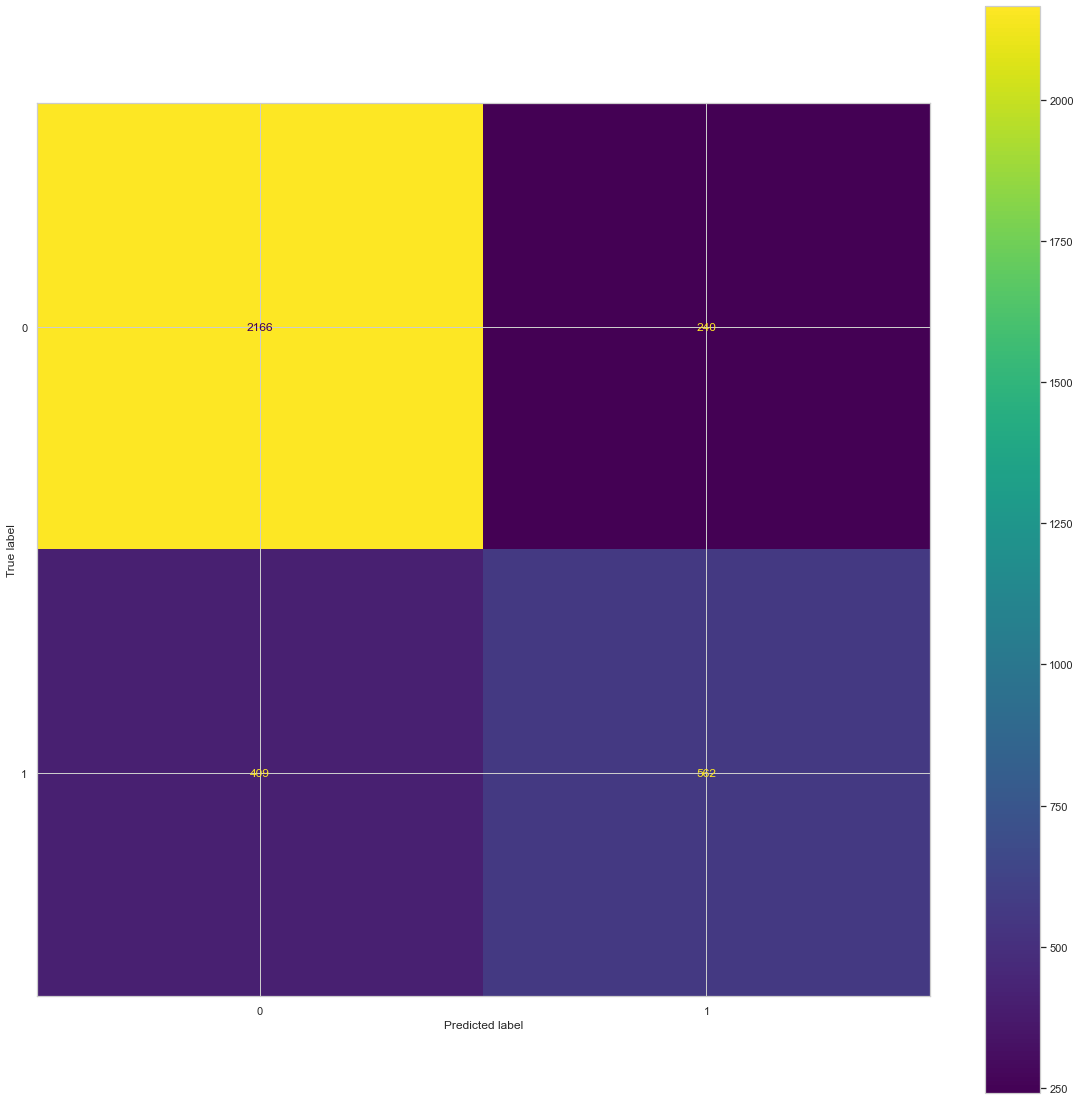

In [52]:
ConfusionMatrixDisplay(confusion_matrix(y_te_samp, rf_clf_sm2.predict(X_te_sc))).plot();

![a bargraph comparing the model's performance on training and testing data](images/Model_Performance_Train_Test.png)

Our model performed with 83% accuracy & 88% precision on the training data, while it was 80% accurate with 70% precision on the testing data.


In [53]:
feature_importances= rf_clf_sm2.feature_importances_

In [54]:
X_tr_smote

array([[-0.49462582, -0.40131033, -0.49431659, ..., -0.06026364,
         1.42026955, -0.556422  ],
       [ 2.02173027, -0.40131033, -0.49431659, ..., -0.82232408,
        -1.16387097, -0.556422  ],
       [-0.49462582,  2.49183721, -0.49431659, ...,  1.46385723,
         0.12819929, -0.556422  ],
       ...,
       [-0.49462582,  2.49183721, -0.49431659, ...,  1.46385723,
         0.67116411,  2.75367887],
       [-0.49462582, -0.40131033, -0.49431659, ..., -0.82232408,
         0.82619795, -0.556422  ],
       [-0.49462582, -0.40131033, -0.49431659, ..., -0.78397496,
         0.06317853, -0.556422  ]])

In [55]:
#feature_importance_dict = dict(zip(X_tr_smote.columns, feature_importances))

In [56]:
data= X_sm
data.corr()

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
age_group_18 - 34 Years,1.000000,-0.197280,-0.244850,-0.258037,-0.290092,0.017819,0.129127,0.066571,-0.129231,-0.060616,...,0.025917,-0.183474,-0.013108,0.020768,0.016497,-0.074593,-0.025974,0.034388,0.195026,0.194887
age_group_35 - 44 Years,-0.197280,1.000000,-0.197234,-0.207857,-0.233678,0.020794,0.051216,0.003794,-0.047220,-0.009780,...,0.024227,-0.036864,-0.005898,0.036261,0.032107,-0.053242,-0.008853,0.034629,0.028164,0.361452
age_group_45 - 54 Years,-0.244850,-0.197234,1.000000,-0.257977,-0.290024,0.007566,-0.015944,0.008266,-0.000337,0.005708,...,0.032470,-0.016505,-0.001992,-0.001748,0.020267,-0.044469,-0.008999,0.011325,0.071002,0.040425
age_group_55 - 64 Years,-0.258037,-0.207857,-0.257977,1.000000,-0.305644,-0.022945,-0.052315,-0.022342,0.060250,-0.001505,...,0.038912,0.032726,0.023255,0.004316,-0.003204,0.039557,0.025985,-0.004689,-0.041026,-0.218747
age_group_65+ Years,-0.290092,-0.233678,-0.290024,-0.305644,1.000000,-0.017964,-0.094354,-0.050186,0.098674,0.059157,...,-0.108863,0.180528,-0.003443,-0.049976,-0.055800,0.113288,0.014428,-0.064548,-0.226045,-0.293839
race_Black,0.017819,0.020794,0.007566,-0.022945,-0.017964,1.000000,-0.076230,-0.073950,-0.585538,0.020885,...,-0.002871,-0.052913,-0.042774,-0.003961,0.065554,-0.057190,-0.042442,0.079974,-0.038686,0.028889
race_Hispanic,0.129127,0.051216,-0.015944,-0.052315,-0.094354,-0.076230,1.000000,-0.064990,-0.514591,-0.018055,...,-0.028429,-0.180724,-0.012210,0.080983,0.089406,-0.015763,0.030088,0.106119,0.104358,0.136132
race_Other or Multiple,0.066571,0.003794,0.008266,-0.022342,-0.050186,-0.073950,-0.064990,1.000000,-0.499201,-0.029986,...,-0.013040,-0.025464,-0.016680,0.009129,0.038411,-0.029405,-0.005817,0.030036,0.046459,0.016037
race_White,-0.129231,-0.047220,-0.000337,0.060250,0.098674,-0.585538,-0.514591,-0.499201,1.000000,0.014454,...,0.026791,0.159916,0.046070,-0.051635,-0.120885,0.065438,0.013894,-0.135792,-0.064282,-0.111204
sex_Female,-0.060616,-0.009780,0.005708,-0.001505,0.059157,0.020885,-0.018055,-0.029986,0.014454,1.000000,...,0.113346,0.063702,0.026500,0.088227,0.091361,0.056747,0.091311,0.042991,-0.063607,0.035745


In [57]:
# Pair feature importances with corresponding column names
if isinstance(X_c, np.ndarray):
    # If X_tr_smote is a NumPy array, use generic feature names
    feature_names = [f'feature_{i}' for i in range(X_c.shape[1])]
else:
    # If X_tr_smote is a DataFrame, use its column names
    feature_names = X_c.columns

feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the sorted feature importances
print("Sorted Feature Importances:")

for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Sorted Feature Importances:
doctor_recc_h1n1: 0.3980680936071827
opinion_h1n1_vacc_effective: 0.25246855544618696
opinion_h1n1_risk: 0.1148107327723949
opinion_seas_risk: 0.10740556615611911
h1n1_knowledge: 0.02227761984460041
health_worker: 0.02124945390068658
race_White: 0.01809572626715784
doctor_recc_seasonal: 0.011082624130527113
opinion_seas_vacc_effective: 0.00935054005945494
respondent_id: 0.009108802188008434
health_insurance: 0.008618931476780908
h1n1_concern: 0.0038798917206360256
chronic_med_condition: 0.0034056198670053195
household_adults: 0.003142802183471779
household_children: 0.0026673107601932217
opinion_seas_sick_from_vacc: 0.00242508721945389
age_group_18 - 34 Years: 0.0019291861172836
census_msa_MSA, Not Principle  City: 0.0018141588542154416
age_group_65+ Years: 0.0017523226808550767
age_group_45 - 54 Years: 0.0017451972863770262
behavioral_avoidance: 0.001466469317513998
sex_Male: 0.0008342709618745959
hhs_geo_region_lzgpxyit: 0.0006291442194956013
opinion_h1n1_

The top three features from our data that went into the model were doctor recommendation for receiving the H1N1 vaccine, opinion on the effectiveness of the H1N1 vaccine, and opinion on the risk of illness from H1N1.

In [58]:
sorted_feature_importance

[('doctor_recc_h1n1', 0.3980680936071827),
 ('opinion_h1n1_vacc_effective', 0.25246855544618696),
 ('opinion_h1n1_risk', 0.1148107327723949),
 ('opinion_seas_risk', 0.10740556615611911),
 ('h1n1_knowledge', 0.02227761984460041),
 ('health_worker', 0.02124945390068658),
 ('race_White', 0.01809572626715784),
 ('doctor_recc_seasonal', 0.011082624130527113),
 ('opinion_seas_vacc_effective', 0.00935054005945494),
 ('respondent_id', 0.009108802188008434),
 ('health_insurance', 0.008618931476780908),
 ('h1n1_concern', 0.0038798917206360256),
 ('chronic_med_condition', 0.0034056198670053195),
 ('household_adults', 0.003142802183471779),
 ('household_children', 0.0026673107601932217),
 ('opinion_seas_sick_from_vacc', 0.00242508721945389),
 ('age_group_18 - 34 Years', 0.0019291861172836),
 ('census_msa_MSA, Not Principle  City', 0.0018141588542154416),
 ('age_group_65+ Years', 0.0017523226808550767),
 ('age_group_45 - 54 Years', 0.0017451972863770262),
 ('behavioral_avoidance', 0.001466469317513

In [59]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(X_c, rowvar=False)

# Find features with correlation 0
zero_correlation_features = [feature for feature, correlation in zip(feature_names, correlation_matrix.mean(axis=1)) if correlation == 0]

# Display features with correlation 0
print("Features with Correlation 0:")
print(zero_correlation_features)

Features with Correlation 0:
[]


## Recommendations 

### Recommendation 1
We recommend reducing features & adjusting parameters to further improve model performance. A feature selection tool could be used to choose features from the dataset


### Recommendation 2
We can dive more into the data & so forthcoming vaccine campaigns can be strategically tailored to resonate with demographics that exhibit a lower inclination towards vaccination. Initial exploration of the data showed lower vaccination rates in Hispanic & Black populations. Healthcare workers typically had a higher vaccination rate



### Recommendation 3
We would recommend investing in community engagement and education programs regarding vaccination to address specific concerns or barriers to vaccination within different vaccination groups. More research into concerns/barriers to vaccinations could also be useful in this instance. Creating strategic partnerships with healthcare providers & organizations may be a way to help optimize vaccine distribution.


### Conclusion
In conclusion, our analysis of the National 2009 H1N1 Flu Survey data provided valuable insights into predicting individuals' decisions on receiving the H1N1 vaccine. The decision tree model, especially after tuning, demonstrated strong performance with 83% accuracy and 88% precision on the training data and 80% accuracy with 70% precision on the testing data. We recommend further model refinement through feature reduction and parameter adjustments for improved performance. Additionally, exploring demographic patterns revealed lower vaccination rates in Hispanic and Black populations, suggesting targeted campaigns and community engagement programs. Addressing concerns and barriers, particularly skepticism in medical care, and fostering strategic partnerships with healthcare providers are essential steps in optimizing future vaccine distribution efforts.



### Next Steps

1. Optimizing Model Precision and Generalization:

2. Conduct a nuanced examination of demographic patterns, utilizing covert analytical methodologies.

3. Initiate community engagement initiatives designed to address specific barriers without drawing undue attention.